In [185]:
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn
import matplotlib.pyplot as plt
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)
plt.style.use('bmh')

## Exploratory Data Analysis (EDA)

In [186]:
df_orig = pd.read_csv("data/challenge3_train.csv")
df_orig.head(5)

,id,target,f0,f1,f2,f3,f4,f5,f6,f7,...,f21,f22,f23,f24,f25,f26,f27,f28,f29,f30
0,0,1,0.0,5.0,0.0,4.0,3598.0,M,3.0,-7.2430,...,3.0,14.2364,0.0,NaN,4.0,1.0,5.0,PS,2.0,0.834041
1,1,0,NaN,5.0,4.0,NaN,2072.0,NaN,4.0,-1.6662,...,3.0,NaN,2.0,3.0,NaN,1.0,5.0,DT,5.0,0.686021
2,2,0,1.0,1.0,4.0,2.0,862.0,M,3.0,-0.1200,...,NaN,NaN,2.0,2.0,3.0,1.0,2.0,vq,5.0,1.141271
3,3,0,NaN,NaN,2.0,1.0,409.0,F,5.0,-16.2169,...,5.0,NaN,2.0,1.0,5.0,1.0,0.0,Bx,5.0,0.662382
4,4,1,NaN,5.0,0.0,3.0,222.0,NaN,5.0,-8.1088,...,5.0,13.9537,4.0,5.0,NaN,1.0,1.0,kB,5.0,-1.000000


We start by removing the 'id' and the 'target' columns, as the first is simply a unique ID for each row, and the second is the target variable. 

In [187]:
df_orig.drop(columns=['id', 'target'], inplace=True)
print(f'Data has {df_orig.shape[0]} rows, each with {df_orig.shape[1]} features.')
df_orig.head(10)
df_orig.head(5)

Data has 50000 rows, each with 31 features.


,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f21,f22,f23,f24,f25,f26,f27,f28,f29,f30
0,0.0,5.0,0.0,4.0,3598.0,M,3.0,-7.2430,13.9681,3.0,...,3.0,14.2364,0.0,NaN,4.0,1.0,5.0,PS,2.0,0.834041
1,NaN,5.0,4.0,NaN,2072.0,NaN,4.0,-1.6662,14.0242,0.0,...,3.0,NaN,2.0,3.0,NaN,1.0,5.0,DT,5.0,0.686021
2,1.0,1.0,4.0,2.0,862.0,M,3.0,-0.1200,14.2174,0.0,...,NaN,NaN,2.0,2.0,3.0,1.0,2.0,vq,5.0,1.141271
3,NaN,NaN,2.0,1.0,409.0,F,5.0,-16.2169,13.8536,0.0,...,5.0,NaN,2.0,1.0,5.0,1.0,0.0,Bx,5.0,0.662382
4,NaN,5.0,0.0,3.0,222.0,NaN,5.0,-8.1088,14.2347,0.0,...,5.0,13.9537,4.0,5.0,NaN,1.0,1.0,kB,5.0,-1.000000


### Missing values
First we check the distribution over missing values for the different features (columns). 

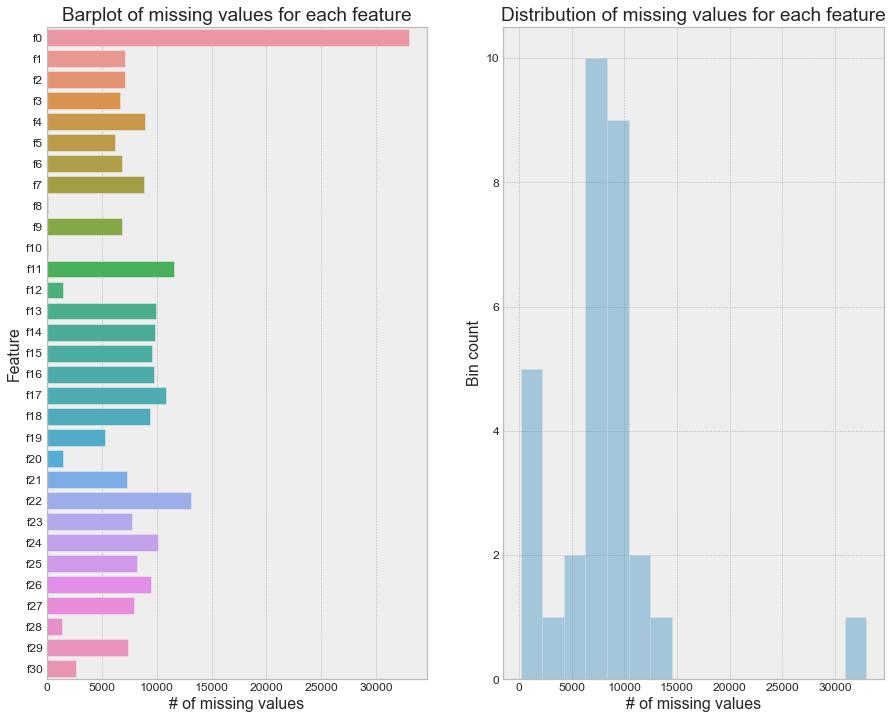

In [188]:
missing_values = df_orig.isna().sum()
fig, ax = plt.subplots(1,2, figsize=(15, 12))
sns.barplot(missing_values.values, missing_values.index, ax=ax[0])
ax[0].set_title("Barplot of missing values for each feature")
ax[0].set_xlabel('# of missing values')
ax[0].set_ylabel('Feature');

sns.distplot(missing_values.values, ax=ax[1], kde=False)
ax[1].set_title("Distribution of missing values for each feature")
ax[1].set_xlabel('# of missing values')
ax[1].set_ylabel('Bin count');


On the left we see a barplot over the number of missing values for each feature. We observe that the feature 'f0' has very many missing values, and that the rest is distributed between 0 to around 13000 missing values. The histogram on the right confirms this. We define a method that will drop all features where the fraction of missing values is above a certain threshold.

In [189]:
def drop_features_with_nan(df, thresh=0.3):
    df2 = df.copy()
    df2 = df2[[column for column in df2 if df2[column].isna().sum() / len(df2) <= thresh]]
    print('Dropped columns: ', end=' ')
    for c in df.columns:
        if c not in df2.columns:
            print(c, end=", ")
    print()
    print(f'# of features after removing those with too many nans: {df2.shape[1]}')
    return df2

In [190]:
df = drop_features_with_nan(df_orig, thresh=0.3)

Dropped columns:  f0, 
# of features after removing those with too many nans: 30


There are still features with many missing values, which needs to be handled. Before we get to that, we explore the different feature types.

### Feature types
We want to find which features are continuous and which are categorical. This is important to know before handling missing values. 

In [191]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 30 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f1      42852 non-null  float64
 1   f2      42885 non-null  float64
 2   f3      43352 non-null  float64
 3   f4      41089 non-null  float64
 4   f5      43792 non-null  object 
 5   f6      43176 non-null  float64
 6   f7      41138 non-null  float64
 7   f8      49855 non-null  float64
 8   f9      43135 non-null  float64
 9   f10     49840 non-null  float64
 10  f11     38383 non-null  float64
 11  f12     48487 non-null  object 
 12  f13     40023 non-null  float64
 13  f14     40132 non-null  float64
 14  f15     40430 non-null  object 
 15  f16     40238 non-null  float64
 16  f17     39102 non-null  float64
 17  f18     40592 non-null  float64
 18  f19     44658 non-null  float64
 19  f20     48488 non-null  object 
 20  f21     42717 non-null  float64
 21  f22     36888 non-null  float64
 22

From this we observe that we have mostly numerical values (float64), and some categorical non-numerical values (object).

In [192]:
numerical_features = [c for c in df.columns if df[c].dtype == 'float64']
categorical = [c for c in df.columns if df[c].dtype == 'object']

In [193]:
print(f'Numerical features:\n{numerical_features} \n')
print(f'Categorical features:\n {non_numerical_features}')


Numerical features:
['f1', 'f2', 'f3', 'f4', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11', 'f13', 'f14', 'f16', 'f17', 'f18', 'f19', 'f21', 'f22', 'f23', 'f24', 'f25', 'f26', 'f27', 'f29', 'f30'] 

Categorical features:
 ['f5', 'f12', 'f15', 'f20', 'f28']


#### Categorical features
Let's check the distributions for each categorical feature. This is useful to know how we should encode them into numerical values.

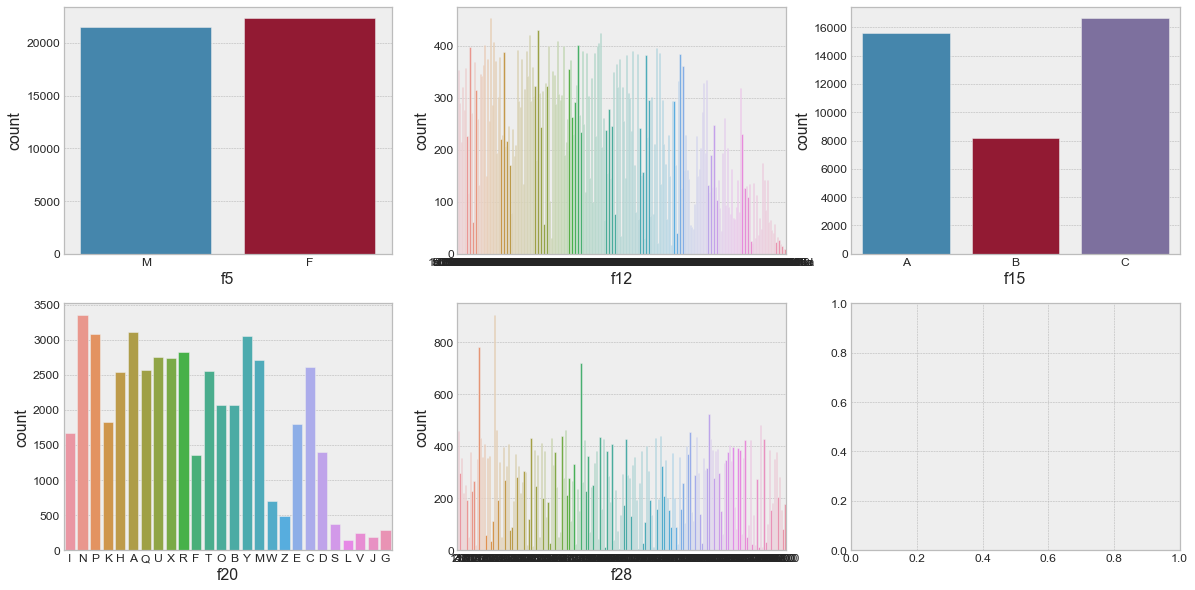

In [198]:
#sns.set(style='whitegrid', palette="deep", font_scale=1.1, rc={"figure.figsize": [8, 5]})
fig, ax = plt.subplots(2, 3, figsize=(20, 10))
for variable, subplot in zip(categorical, ax.flatten()):
    sns.countplot(df[variable], ax=subplot)
    #for label in subplot.get_xticklabels():
     #   label.set_rotation(90)

We observe that the features 'f12' and 'f28' take on quite many values. When converting these to numerical values it therefore seems reasonable to do a simple replace. 

In [214]:
print(f'f12 has {df["f12"].nunique()} unique values')
print(f'f28 has {df["f28"].nunique()} unique values')

f12 has 222 unique values
f28 has 190 unique values


In [210]:
def replace_with_number(df, columns):
    df2 = df.copy()
    for column in columns:
        labels = df2[column].astype('category').cat.categories.tolist()
        replace_map_comp = {column : {k: v for k,v in zip(labels, list(range(1, len(labels) + 1)))}}
        df2.replace(replace_map_comp, inplace=True)
    return df2

In [212]:
df = replace_with_number(df, ['f12', 'f28'])
df[['f12', 'f28']].head()

,f12,f28
0,27.0,55.0
1,201.0,15.0
2,89.0,176.0
3,171.0,8.0
4,6.0,127.0


#### Numerical features

Let's check the distributions for each numerical feature.

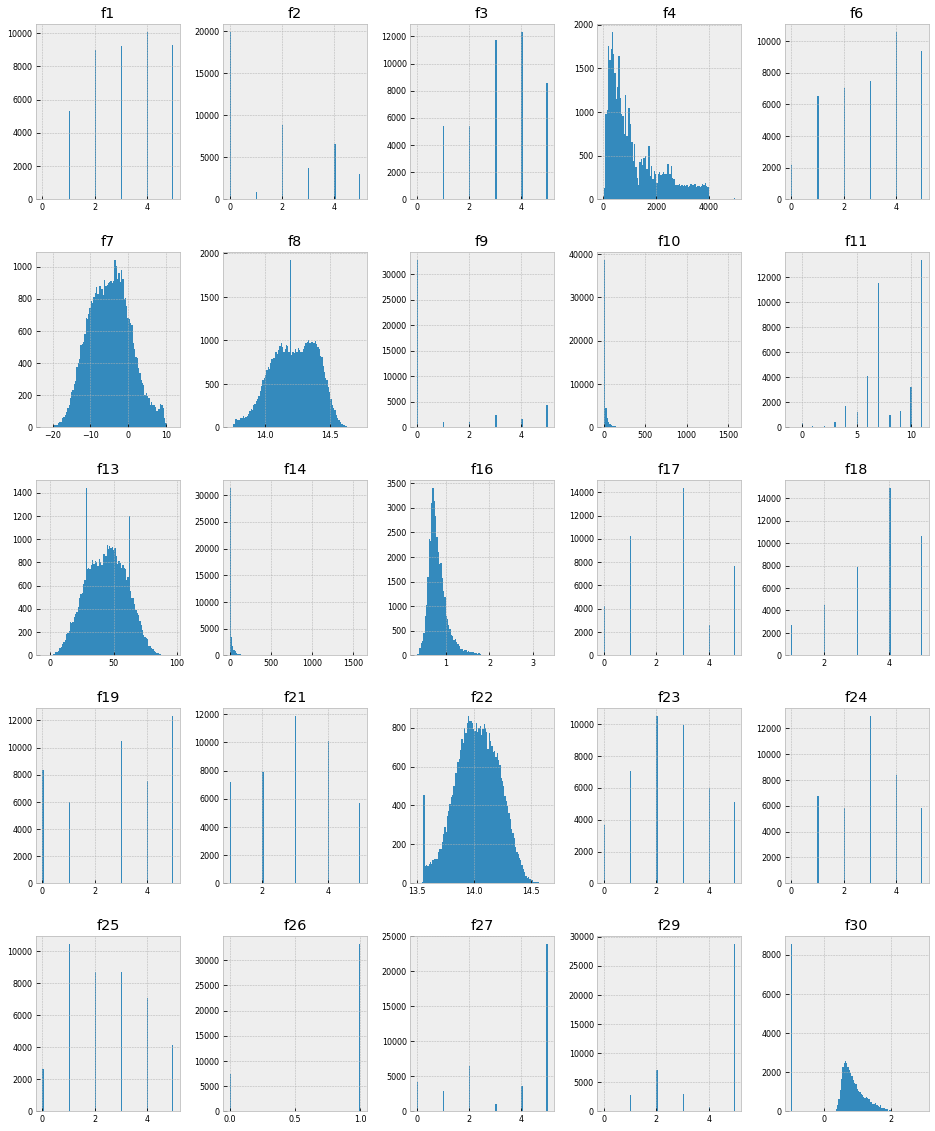

In [148]:
df[numerical_features].hist(figsize=(16, 20), bins=100, xlabelsize=8, ylabelsize=8);

From above it seems like only 9 of the numerical features are continuous (f4, f7, f8, f10, f13, f14, f16, f22 and f30). The rest are discrete numerical values, and can thus be considered categorical. However, these numeric categorical features may or may not have a natural ordering of their values, that is, they can be ordinal or nominal. For instance, the feature "number of rooms in an apartment" is ordinal because a value of 5 is actually less than a value of 10. In contrast, the feature " 
